# Удержание клиентов магазина

Задание:

* К вам приходит руководитель продукта “Интернет-магазин”
* И спрашивает про удержание клиентов и повторные покупки
* У него есть опасение, что из-за проблем с доставкой товаров в магазине у нас стали больше оттекать пользователи
* Он просит вас сравнить, на сколько сейчас все хуже, чем в прошлом году? 

Данные лежат в папке занятия на сервере:

* есть транзакции (покупки) в интернет магазине, в том числе id клиента, id покупки, timestamp покупки и тп
* orders.csv, customers.csv  

Ваши задачи: 

* Проверить гипотезу руководителя продукта 
* Дать руководителю продукта инструмент для самостоятельного принятия решений по качеству удержания пользовательской базы

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

### 1. Загрузка данных:

In [2]:
customers = pd.read_csv('customers.csv')
customers.head(3)

,id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale


In [3]:
orders = pd.read_csv('orders.csv')
orders.head(3)

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056


### 2. Исследование исходных данных

Сперва посмотрим на клиентские данные: в дальнейшем можно будет разделить клиентов на когорты по сегментам.

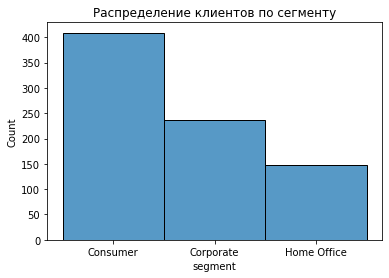

In [4]:
sns.histplot(customers, x = 'segment')
plt.title('Распределение клиентов по сегменту')
plt.show()

Топ 10 штатов:

In [5]:
(
    customers
    .groupby('state')
    .count()['id']
    .sort_values(ascending = False)
    .head(10)
    .to_frame()
    .rename(columns = {'id': 'count'})
)

,count
state,
California,161
New York,87
Texas,77
Pennsylvania,50
Illinois,41
Washington,38
Ohio,38
North Carolina,30
Florida,24


Теперь посмотрим на данные по заказам:

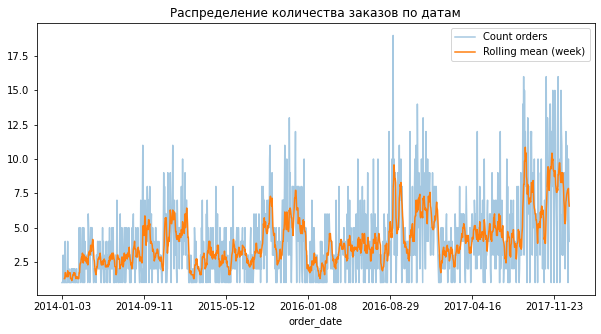

In [6]:
plt.figure(figsize = (10,5))
dates = orders.groupby('order_date').count()['customer_id']
dates.plot(alpha = 0.4, label = 'Count orders')
dates.rolling(7).mean().plot(label = 'Rolling mean (week)')
plt.title('Распределение количества заказов по датам')
plt.legend()
plt.show()

* В предложенном датасете представлены данные с 2014 по 2017. 
* В данных явно видна сезонность по годам и месяцам

Статистики для суммы заказов

In [7]:
orders.sales.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
sales,5009.0,458.614666,954.730953,0.556,37.63,151.96,512.064,23661.228


C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


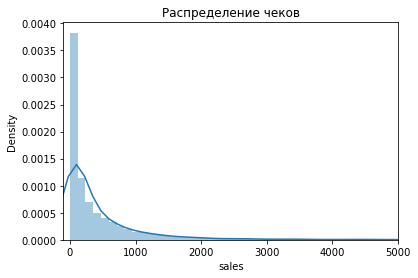

In [8]:
sns.distplot(orders.sales, bins = 200)
plt.xlim(-100, 5000)
plt.title('Распределение чеков')
plt.show()

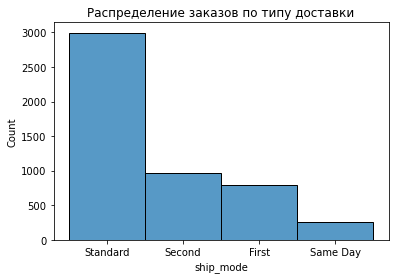

In [9]:
sns.histplot(orders, x = 'ship_mode')
plt.title('Распределение заказов по типу доставки')
plt.show()

### 3. Сравнение параметров за 2 года: 

In [10]:
orders['order_date'] = pd.to_datetime(orders['order_date'])

**1. Общая сумма и количество заказов**

In [11]:
orders.groupby(orders.order_date.dt.year).sum()['sales'].to_frame().round().T

order_date,2014,2015,2016,2017
sales,484247.0,470533.0,609206.0,733215.0


In [12]:
orders.groupby(orders.order_date.dt.year).count()['sales'].to_frame().round().T

order_date,2014,2015,2016,2017
sales,969,1038,1315,1687


In [13]:
orders.groupby(orders.order_date.dt.year).mean()['sales'].to_frame().round().T

order_date,2014,2015,2016,2017
sales,500.0,453.0,463.0,435.0


**2. Сумма и количество заказов по месяцам**

Код из этого раздела можно переиспользовать для сравнения двух лет в дальнейшем. Для этого необходимо в следующей ячейке заменить года на нужные. 

In [14]:
first_year = 2016
second_year = 2017

In [15]:
first_data = orders.loc[pd.DatetimeIndex(orders['order_date']).year == first_year]
second_data = orders.loc[pd.DatetimeIndex(orders['order_date']).year == second_year]

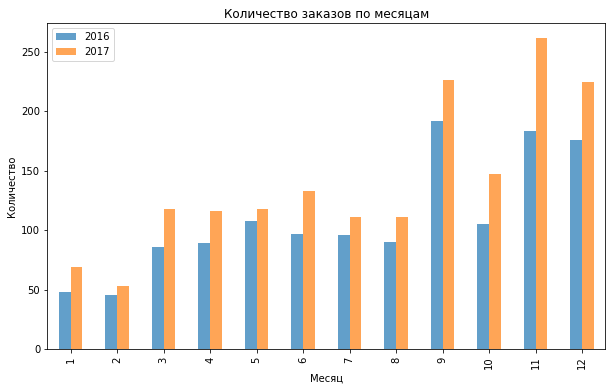

In [16]:
df1 = first_data.groupby(pd.DatetimeIndex(first_data['order_date']).month).count()['id'].to_frame().rename(columns = {'id':first_year})
df2 = second_data.groupby(pd.DatetimeIndex(second_data['order_date']).month).count()['id'].to_frame().rename(columns = {'id':second_year})

df3 = pd.concat([df1.T, df2.T], axis=0, ignore_index=False)

df3.T.plot.bar(alpha = 0.7, figsize = (10, 6))
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.show()

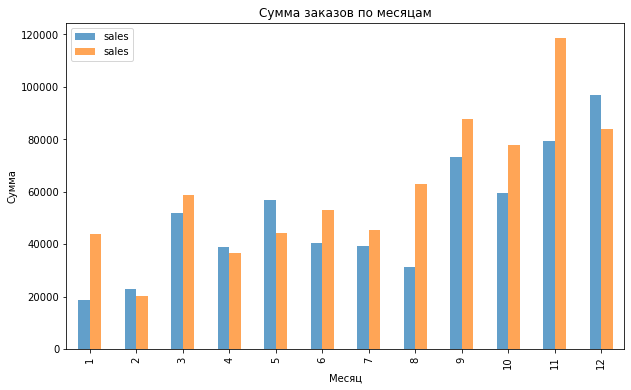

In [17]:
df1 = first_data.groupby(pd.DatetimeIndex(first_data['order_date']).month).sum()['sales'].to_frame().rename(columns = {'id':first_year})
df2 = second_data.groupby(pd.DatetimeIndex(second_data['order_date']).month).sum()['sales'].to_frame().rename(columns = {'id':second_year})

df3 = pd.concat([df1.T, df2.T], axis=0, ignore_index=False)

df3.T.plot.bar(alpha = 0.7, figsize = (10, 6))
plt.title('Сумма заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма')
plt.show()

**Выводы:** 
* Количество заказов увеличилось
* Средняя сумма заказов за год увеличилась, в некоторые месяца становится чуть меньше, но не сильно
* Средний чек уменьшился  

Можно сделать предположение, что в магазине появились новые клиенты, средний чек которых меньше, чем у старых. 

### 3. Исследование данных по клиентам

Необходимо разделить пользователей на когорты. 
* Временем прихода клиента будем считать дату первого заказа. 
* Ушедшим клиентом будем считать такого, который сделал последний заказ год или больше назад.

Для каждого клиента посчитаем даты первого и последнего заказа, а также средний чек и количество заказов.

In [18]:
agg_dict = {
    'order_date' : ['min', 'max'],
    'sales' : ['mean', 'count']
}

In [19]:
info = orders.groupby('customer_id').agg(agg_dict)

In [20]:
info.columns = ['min_order_date', 'max_order_date', 'mean_sales', 'count_sales']

In [21]:
customers_info = customers.merge(info, left_on = 'id', right_on = 'customer_id', how = 'left')

In [22]:
customers_info['cohort_month'] = pd.to_datetime(customers_info['min_order_date'], infer_datetime_format=True).dt.strftime('%Y-%m') 

In [23]:
customers_info['cohort_year'] = pd.to_datetime(customers_info['min_order_date'], infer_datetime_format=True).dt.year 

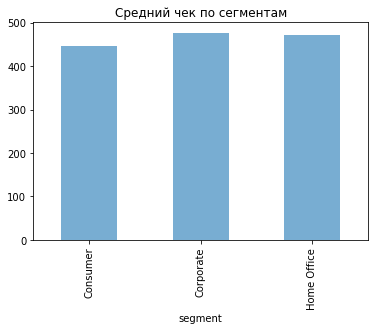

In [24]:
customers_info.groupby('segment').mean()['mean_sales'].plot.bar(alpha = 0.6)
plt.title('Средний чек по сегментам')
plt.show()

Средняя сумма заказа отличается не слишком значительно, поэтому дальше разбиение по ним учитывать не будем. Однако надо отметить, что корпоративные клиенты делают более крупные заказы (это логично).

Посмотрим, когда к нам приходили клиенты (распределение по когортам):

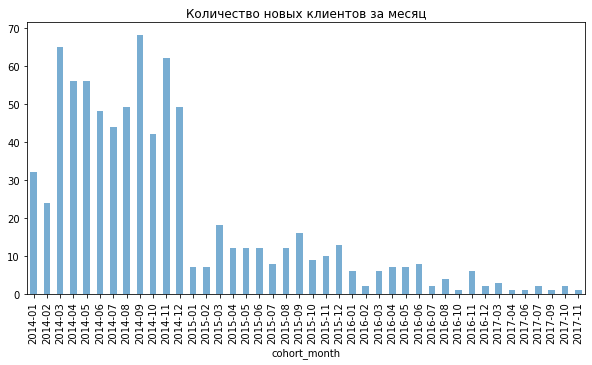

In [25]:
customers_info.groupby('cohort_month').count()['mean_sales'].plot.bar(alpha = 0.6, figsize = (10, 5))
plt.title('Количество новых клиентов за месяц')
plt.show()

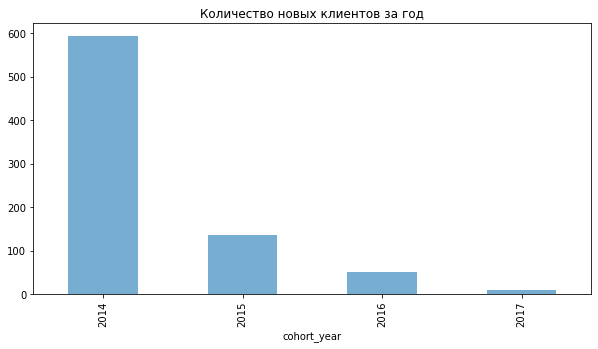

In [26]:
customers_info.groupby('cohort_year').count()['mean_sales'].plot.bar(alpha = 0.6, figsize = (10, 5))
plt.title('Количество новых клиентов за год')
plt.show()

На данный момент еще не выяснили, как дела с оттоком, но с притоком новых клиентов точно что-то не так.  
**Приток новых клиентов падает с каждым годом.**

### 4. Исследование данных по заказам

Основная часть задания: необходимо выяснить, не увеличился ли отток клиентов и совершаются ли в 2017 году повторные заказы.

По графикам из п.2 видно, что в целом к концу года количество заказов не падает (а даже растет). Посмотрим теперь именно на повторные заказы.

**1. Количество повторных заказов**

In [27]:
repeat = orders.groupby(orders.order_date.dt.year).agg({'customer_id': pd.Series.nunique})

In [28]:
count = orders.groupby([orders.order_date.dt.year, orders.customer_id]).count()
count['year'] = count.index.get_level_values(0)
count['ids'] = count.index.get_level_values(1)
count = count.loc[count.sales > 1].groupby('year').agg({'ids': pd.Series.nunique})

In [29]:
repeat = repeat.merge(count, left_index=True, right_index=True)
repeat.columns = ['num_clients', 'repeat_clients']
repeat['part'] = (100*repeat.repeat_clients/repeat.num_clients).round()

In [30]:
repeat

,num_clients,repeat_clients,part
order_date,,,
2014,595,263,44.0
2015,573,311,54.0
2016,638,377,59.0
2017,693,493,71.0


Из всех 693 клиентов, которые совершали заказы в 2017 году, около **71%** совершили повторный заказ. 

Из всех 693 клиентов, которые совершали заказы в 2016 году, около **59%** совершили повторный заказ. Это меньше, чем в 2017. Значит, ситуация с повторными заказами в 2017 даже улучшилась.

Я не разбивала на когорты в этом пункте. Целью было проверить гипотезу о том, что проблемы с доставкой в 2017 повлияли на совершение заказов. А этот фактор может оказывать одинаковое влияние как на вновь пришедших, так и на старых клиентов. К тому же, в 2017 году пришло только 11 новых клиентов - выборка не репрезентативна.

**2. Отток клиентов**

In [31]:
orders_info = orders.merge(customers_info, left_on = 'customer_id', right_on = 'id', how = 'left')
orders_info['order_year'] = orders_info.order_date.dt.year
orders_info['order_month'] = orders_info.order_date.dt.strftime('%Y-%m')

In [32]:
def cohort_column(df):
    df['cohort_period'] = np.arange(len(df))
    return df

In [33]:
orders_year = (orders_info
                  .groupby(['cohort_year', 'order_year']).agg({'customer_id': pd.Series.nunique})
                  .groupby(level=0).apply(cohort_column)
                  .rename(columns = {'customer_id': 'unique_customers'})
                  .reset_index()
                  .set_index(['cohort_year', 'cohort_period']) 
               )
cohort_group_size = orders_year['unique_customers'].groupby(level=0).first()
user_retention = orders_year['unique_customers'].unstack(0).divide(cohort_group_size, axis=1)

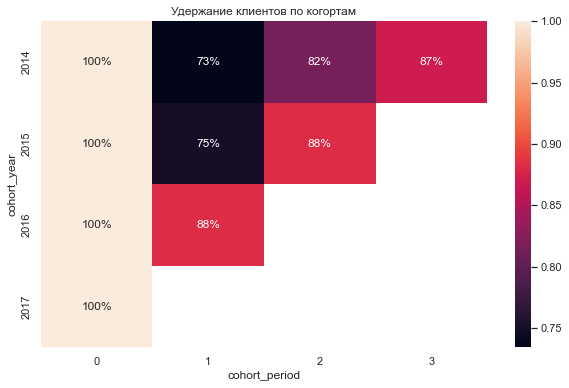

In [34]:
sns.set(style='white')
plt.figure(figsize=(10, 6))
plt.title('Удержание клиентов по когортам')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%')
plt.show()

Аналогичная диаграмма с разбиением по месяцам бесполезна - в когортах 2016 и 2017 слишком мало людей. Но на основе этой диаграммы можно сделать вывод - в 2017 году не было проблем с оттоком клиентов, более того - старые клиенты стали совершать больше заказов.

**3. Средний чек по годам и когортам**

Ранее заметили, что уменьшился средний чек. Посмотрим подробнее:

In [35]:
orders_sales = (orders_info
                  .groupby(['cohort_year', 'order_year']).mean()['sales']
                  .to_frame()
                  .groupby(level=0).apply(cohort_column)
                  .reset_index()
                  .set_index(['cohort_year', 'cohort_period']) 
               )

mean_sales = orders_sales['sales'].unstack(0).round(2)

In [36]:
mean_sales

cohort_year,2014,2015,2016,2017
cohort_period,,,,
0,499.74,456.23,526.96,395.36
1,452.47,462.76,479.58,NaN
2,456.74,449.74,NaN,NaN
3,427.10,NaN,NaN,NaN


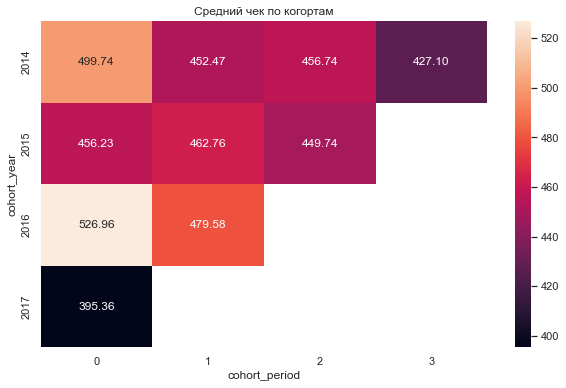

In [37]:
sns.set(style='white')
plt.figure(figsize=(10, 6))
plt.title('Средний чек по когортам')
sns.heatmap(mean_sales.T, mask=mean_sales.T.isnull(), annot=True, fmt='.2f')
plt.show()

В 2017 году средний чек уменьшился у всех когорт пользователей!

## Выводы: 

Ответы на поставленные вопросы:
* **Отток клиентов не наблюдается** - наоборот, старые клиенты стали делать больше заказов.
* **Повторных заказов в данном году больше**, чем в предыдущем.  

Следовательно, проблемы с доставкой не оказали существенного влияния на эти показатели.  

Однако, в ходе исследования обнаружились другие проблемы: 
* **Приток новых клиентов значительно падает** каждый год.
* В данном году **средний чек снизился** по всем клиентам по сравнению с прошлыми годами.

Скорее всего они не были вызваны проблемами с доставкой, необходимо искать причины в другом.

**Инструмент для аналитики**

Данный ноутбук оформлен таким образом, чтобы его можно было переиспользовать на дополненных данных. Он содержит таблицы и диаграммы со следующими метриками:
* Количество заказов по месяцам
* Сумма заказов по месяцам
* Общая сумма, количество и средний чек заказов
* Доля клиентов, сделавших повторный заказ
* Приток клиентов по месяцам и годам
* Удержание клиентов по годовым когортам
* Средний чек по годовым когортам

Они позволяют составить представление о положении, в котором находится продукт (интернет-магазин)